In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.spatial
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import hamming, pdist, squareform
from sklearn.metrics import jaccard_score

In [56]:
df = pd.read_parquet("wbmasterf.parquet")

In [57]:
legend = df.groupby(["child_id"]).first()[["ageg", "sex", "production", "age"]].reset_index()

In [58]:
df["child_id"].nunique()

4831

In [59]:
legend.shape

(4831, 5)

# **Part 4A: Evaluating the recommendation model**

Since we are no longer segmenting our data, our user-item matrix will include the interaction history of *all* existing users, across age and sex. Our EDA revealed that there are significant differences in the quality and quantity of the vocabulary of children, depending on their age and sex. Therefore, by inputting the information of a user, our model should be able to guess their age and sex. 

While the goal of the model is of course not to predict a user's demographic characteristics, it *is* important to ensure that the recommended items do take the child's current developmental stage into consideration. For age-appropriate items to be recommended to the user, our model should (overall) be identifying users of a similar age to our target user as neighbours.

First, I will extract 5 children per possible age/sex combination.

In [60]:
testusers = df.drop_duplicates(subset="child_id")
testusers = df.groupby(["ageg", "sex"])["child_id"].sample(5)

Create a new df with only the information of our chosen test users; remove the test users from our "training data".

In [61]:
mask = df["child_id"].isin(testusers)
testdata = df[mask]

In [62]:
df = df[~mask]

Now introduce the CF model we built in Part 3:

In [63]:
user_item_matrix = df.pivot(index="child_id", columns="item_id", values="value")
itemsorted = sorted(user_item_matrix.columns, key=lambda x: int(x.split("_")[1]))
user_item_matrix = user_item_matrix[itemsorted]
user_item_matrix.columns = [f"item_{int(col.split('_')[1]) - 1}" if col.startswith("item_") else col for col in user_item_matrix.columns]

In [64]:
target_item_matrix = user_item_matrix.T
itemsim = (scipy.spatial.distance.cdist(target_item_matrix.values, target_item_matrix.values, metric='jaccard'))

In [65]:
knn = NearestNeighbors(n_neighbors=5, metric='jaccard', algorithm='brute')
knn.fit(user_item_matrix)

NearestNeighbors(algorithm='brute', metric='jaccard')

Create a for loop, in which the interaction history of our test users is used to determine which of our training users are most similar to them.

In [104]:
user_item_matrix[user_item_matrix.index == 84852]

,item_0,item_1,item_2,item_3,item_4,item_5,item_6,item_7,item_8,item_9,...,item_670,item_671,item_672,item_673,item_674,item_675,item_676,item_677,item_678,item_679
child_id,,,,,,,,,,,,,,,,,,,,,


In [143]:
def collect_interaction_history(testusers, testdata, knn, user_item_matrix, legend):
    interaction_history = {}
    for user in testusers:
        user_interactions = testdata[testdata["child_id"] == user]["value"].tolist()
        distance, neighbor_indices = knn.kneighbors([user_interactions])
        neighbor_indices = neighbor_indices[0]
        neighbor_id = user_item_matrix.index[neighbor_indices]
        neighbors_info = legend[legend["child_id"].isin(neighbor_id)][["child_id", "ageg", "sex"]]
        interaction_history[user] = distance, neighbor_id, neighbors_info

    data = []
    for user, (distance, neighbor_id, neighbors_info) in interaction_history.items():
        user_sex = legend[legend["child_id"] == user]["sex"].iloc[0]
        user_age = legend[legend["child_id"] == user]["ageg"].iloc[0]

        for i in range(len(neighbor_id)):
            data.append([user, neighbor_id[i], user_age, neighbors_info.iloc[i]["ageg"], user_sex, neighbors_info.iloc[i]["sex"], distance[0][i]])

    # Create a DataFrame from the collected data
    columns = ["User_ID", "Neighbor_ID", "User_Age", "Neighbor_Age", "User_Sex", "Neighbor_Sex", "Dissimilarity_Score"]
    result_df = pd.DataFrame(data, columns=columns)

    return result_df

Running the function returns **`result_df`**, containing demographic information for all of the 5 found neighbours of each test user, and also the test users themselves.

In [147]:
result_df = collect_interaction_history(testusers, testdata, knn, user_item_matrix, legend)

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/metrics/pairwise.py:2181: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)
/Users/sonia/anaconda3/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(
/Users/sonia/anaconda3/

Calculate the mean dissimilarity score across all found neighbours for each user.

In [148]:
result_df.head(5)

,User_ID,Neighbor_ID,User_Age,Neighbor_Age,User_Sex,Neighbor_Sex,Dissimilarity_Score
0,84852,86144,1,2,Female,Female,0.578947
1,84852,84644,1,1,Female,Male,0.585366
2,84852,84895,1,2,Female,Female,0.606061
3,84852,85833,1,3,Female,Male,0.625000
4,84852,84847,1,5,Female,Male,0.628571


For each user, the average dissimilarity score across all neighbours:

In [68]:
dismean = result_df.groupby("User_ID")["Dissimilarity_Score"].mean().reset_index()

"Vote" for a final prediction for each test user's age group and sex by finding the mode of their 5 neighbours. Put the results together in a df with each user's actual stats.

In [77]:
#most of this info is already in result_df, y am i collecting it again?
predicted_age_sex = result_df.groupby("User_ID")[["Neighbor_Age", "Neighbor_Sex"]].agg(lambda x: x.mode().iloc[0])

true_info = legend[["child_id", "ageg", "sex"]]

finalpred = predicted_age_sex.merge(true_info, left_index=True, right_on="child_id")

finalpred = finalpred.merge(dismean, left_on="child_id", right_on="User_ID")

finalpred = finalpred.rename(columns={"ageg": "true_age", "sex": "true_sex", "Neighbor_Age": "predicted_age", "Neighbor_Sex": "predicted_sex"})

finalpred["agetrue"] = finalpred["true_age"] == finalpred["predicted_age"]
finalpred["sextrue"] = finalpred["true_sex"] == finalpred["predicted_sex"]

finalpred = finalpred.drop(columns="child_id")

finalpred = finalpred.reset_index(drop=True)

In [78]:
finalpred = finalpred[["User_ID", "true_age", "predicted_age", "true_sex", "predicted_sex", "agetrue", "sextrue", "Dissimilarity_Score"]]
finalpred = finalpred.sort_values(["true_age", "true_sex"])
finalpred

,User_ID,true_age,predicted_age,true_sex,predicted_sex,agetrue,sextrue,Dissimilarity_Score
3,275,1,1,Female,Male,True,False,0.556667
10,1565,1,1,Female,Female,True,True,0.652793
25,84573,1,1,Female,Male,True,False,0.617064
26,84678,1,1,Female,Male,True,False,0.770574
29,84852,1,2,Female,Male,False,False,0.604789
6,793,1,2,Male,Male,False,True,0.648630
8,1045,1,2,Male,Male,False,True,0.605450
9,1536,1,2,Male,Male,False,True,0.595085
28,84823,1,3,Male,Female,False,False,0.660911
46,86386,1,2,Male,Female,False,False,0.571990


In [79]:
#with 5 neighbors
print("\033[1mSummary:\033[0m")
print()
print("Number of correct predictions for AGE:", finalpred["agetrue"].sum())
print("Number of correct predictions for SEX:", finalpred["sextrue"].sum())

Summary:

Number of correct predictions for AGE: 19
Number of correct predictions for SEX: 35


Not necessarily amazing results, but for **`ageg`** (age group) we have to keep in mind that a prediction of `2` for a target user belonging to age group `1` is not "as wrong" as a prediction of `5` would be. A binary true or false metric doesn't provide detailed information on the accuracy of the predictions.

Also, predictions were calculated using the mode of the neighbours, without taking their respective similarity scores into account. Ideally, demographic data stemming from neighbours rated as highly similar to the user would be weighted more heavily than that from neighbours with lower similarity.

The sample size for each group is also relatively small and not the same across all ages and sexes, which could also explain why (at least according to the few test runs I made) the age of users belonging to age group `5` is guessed very accurately (this group has the highest n). Additionally, this age group is the most likely to have interacted with items that all other age groups have not. This means they will have more overlapping interactions that are unique to this specific age group, unlike age group `1` for example, whose limited interactions i.e. limited vocabulary will consist of words that users of *all* age groups have also already learned.

Sex differences in vocabulary are also not uniform across all age groups (sex x age interaction term of anova, plus top 5 categories by age and sex). For certain age groups, they are more pronounced, and for others non-existent, hence it should be easier to make sex predictions for specific age groups. 

Also note that much variation in vocabulary can exist even between children who are of the same age. A lingusitically "gifted" user's interaction history will be more closely associated with age groups above its own, rather than its own.

***

## Extra: Additional explorations and visualizations

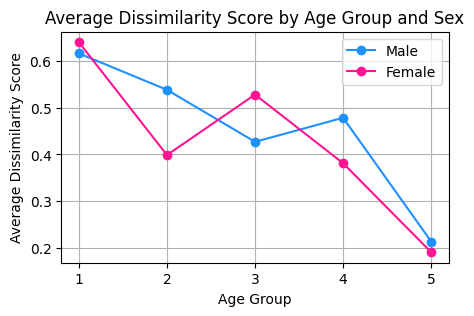

In [80]:
grouped_data = finalpred.groupby(["true_age", "true_sex"])["Dissimilarity_Score"].mean().unstack()
age_groups = grouped_data.index

plt.figure(figsize=(5, 3))

plt.plot(age_groups, grouped_data["Male"], marker="o", label="Male", linestyle="-", color="dodgerblue")
plt.plot(age_groups, grouped_data["Female"], marker="o", label="Female", linestyle="-", color="deeppink")

plt.title('Average Dissimilarity Score by Age Group and Sex')
plt.xlabel('Age Group')
plt.ylabel('Average Dissimilarity Score')
plt.xticks(age_groups)
plt.legend()

plt.grid()
plt.show()

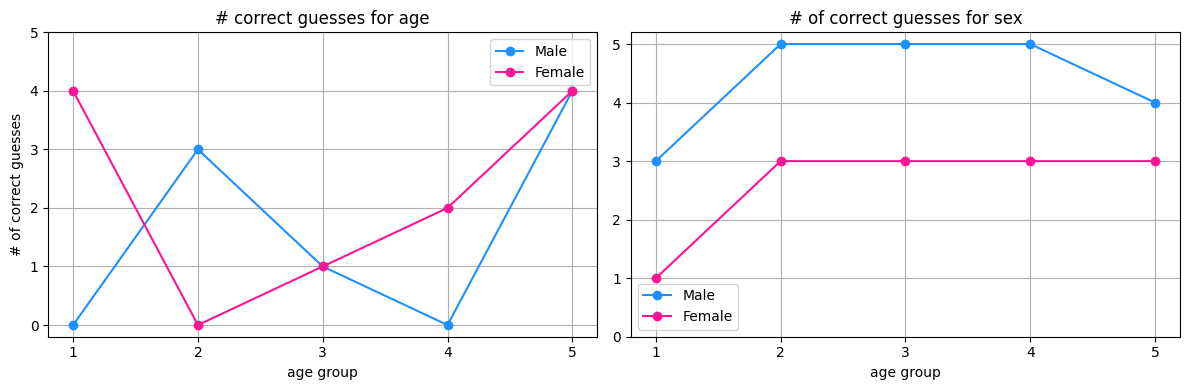

In [90]:
grouped2 = finalpred.groupby(["true_age", "true_sex"])["agetrue"].sum().unstack()
grouped3 = finalpred.groupby(["true_age", "true_sex"])["sextrue"].sum().unstack()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(grouped2.index.astype(str), grouped2["Male"], marker="o", label="Male", color="dodgerblue")
ax1.plot(grouped2.index.astype(str), grouped2["Female"], marker="o", label="Female", color="deeppink")

ax1.set_title("# correct guesses for age")
ax1.set_xlabel("age group")
ax1.set_ylabel("# of correct guesses")
ax1.set_xticks(grouped2.index)
ax1.set_yticks([0, 1, 2, 3, 4, 5])

ax1.grid()
ax1.legend()

ax2.plot(grouped3.index.astype(str), grouped3["Male"], marker="o", label="Male", color="dodgerblue")
ax2.plot(grouped3.index.astype(str), grouped3["Female"], marker="o", label="Female", color="deeppink")

ax2.set_title("# of correct guesses for sex")
ax2.set_xlabel("age group")
ax2.set_xticks(grouped3.index)
ax2.set_yticks([0, 1, 2, 3, 4, 5])

ax2.grid()
ax2.legend()

plt.tight_layout()
plt.show()